final project
===
due: June 30 2022

authors: pegler, prüwasser, scheftner

In [1]:
import pandas as pd

In [6]:
df = pd.read_csv("data/final_data/masterfile_clean.csv", sep=";", index_col=0)

In [24]:
from glob import glob

In [27]:
files = glob("data/final_data/*.csv")

In [30]:
dfs = []

for file in files:

    dfs.append(pd.read_csv(file, sep=";", index_col=0))

In [40]:
files[7]

'data/final_data/auc_ec_eo.csv'

In [39]:
dfs[7]

,Factor,Power,Time,ROI,Frequency,Eyes
id,,,,,,
1,ALPHA_aucp_PRE_EC_midline,0.435400,Pre,Midline,Alpha,EC
2,ALPHA_aucp_PRE_EC_midline,0.507740,Pre,Midline,Alpha,EC
3,ALPHA_aucp_PRE_EC_midline,0.432640,Pre,Midline,Alpha,EC
4,ALPHA_aucp_PRE_EC_midline,0.364580,Pre,Midline,Alpha,EC
5,ALPHA_aucp_PRE_EC_midline,0.157420,Pre,Midline,Alpha,EC
...,...,...,...,...,...,...
10,DELTA_aucp_POST_EO_parietotemporalPURE,0.225500,Post,Parietotemporal,Delta,EO
11,DELTA_aucp_POST_EO_parietotemporalPURE,0.152475,Post,Parietotemporal,Delta,EO
12,DELTA_aucp_POST_EO_parietotemporalPURE,0.173900,Post,Parietotemporal,Delta,EO


In [47]:
files[13]

'data/final_data/auc_ec_eo_with_gamma.csv'

In [55]:
dfs[13]

,Factor,Power,Time,ROI,Frequency,Eyes
id,,,,,,
1,GAMMA_aucp_PRE_EC_midline,0.003900,Pre,Midline,Gamma,EC
2,GAMMA_aucp_PRE_EC_midline,0.004960,Pre,Midline,Gamma,EC
3,GAMMA_aucp_PRE_EC_midline,0.006120,Pre,Midline,Gamma,EC
4,GAMMA_aucp_PRE_EC_midline,0.011220,Pre,Midline,Gamma,EC
5,GAMMA_aucp_PRE_EC_midline,0.023780,Pre,Midline,Gamma,EC
...,...,...,...,...,...,...
10,DELTA_aucp_POST_EO_parietotemporalPURE,0.225500,Post,Parietotemporal,Delta,EO
11,DELTA_aucp_POST_EO_parietotemporalPURE,0.152475,Post,Parietotemporal,Delta,EO
12,DELTA_aucp_POST_EO_parietotemporalPURE,0.173900,Post,Parietotemporal,Delta,EO


In [53]:
dfs[13].groupby(["Time"]).mean()

,Power
Time,
Post,0.155794
Pre,0.158965


In [54]:
dfs[13].groupby(["ROI"]).mean()

,Power
ROI,
Midline,0.159898
Parietotemporal,0.154861


In [57]:
dfs[13].groupby(["Frequency"]).mean()

,Power
Frequency,
Alpha,0.240530
Delta,0.189019
Gamma,0.018415
Theta,0.181554


In [58]:
dfs[13].groupby(["Eyes"]).mean()

,Power
Eyes,
EC,0.164223
EO,0.150536


In [60]:
dfs[13].groupby(["Frequency", "Eyes"]).mean()

Power
Frequency Eyes          
Alpha     EC    0.293311
          EO    0.187748
Delta     EC    0.173065
          EO    0.204972
Gamma     EC    0.015949
          EO    0.020882
Theta     EC    0.174566
          EO    0.188541

In [61]:
dfs[13].groupby(["Time", "Frequency", "Eyes"]).mean()

Power
Time Frequency Eyes          
Post Alpha     EC    0.305729
               EO    0.190367
     Delta     EC    0.168508
               EO    0.197538
     Gamma     EC    0.015249
               EO    0.021493
     Theta     EC    0.165505
               EO    0.181960
Pre  Alpha     EC    0.280893
               EO    0.185128
     Delta     EC    0.177623
               EO    0.212406
     Gamma     EC    0.016648
               EO    0.020272
     Theta     EC    0.183627
               EO    0.195122

In [65]:
df_grp = dfs[13].groupby(["Time", "Frequency", "ROI"]).mean().reset_index()
df_grp

,Time,Frequency,ROI,Power
0,Post,Alpha,Midline,0.234329
1,Post,Alpha,Parietotemporal,0.261767
2,Post,Delta,Midline,0.201376
3,Post,Delta,Parietotemporal,0.164670
4,Post,Gamma,Midline,0.015928
5,Post,Gamma,Parietotemporal,0.020814
6,Post,Theta,Midline,0.187758
7,Post,Theta,Parietotemporal,0.159707
8,Pre,Alpha,Midline,0.212806
9,Pre,Alpha,Parietotemporal,0.253216


In [63]:
import matplotlib.pyplot as plt 

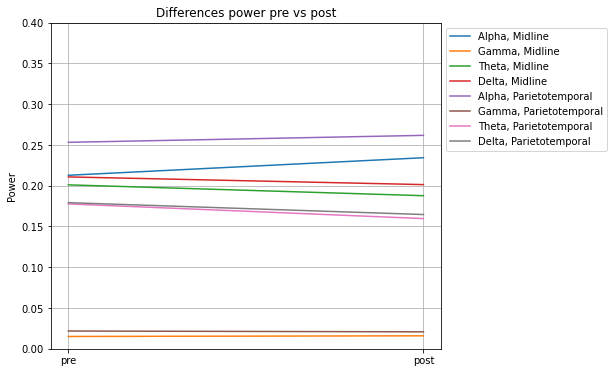

In [104]:
plt.figure(figsize=(7, 6))

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Alpha, Midline")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Gamma, Midline")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Theta, Midline")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Delta, Midline")

#

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Alpha, Parietotemporal")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Gamma, Parietotemporal")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Theta, Parietotemporal")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Delta, Parietotemporal")

plt.ylim(0, 0.4)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Differences power pre vs post")
plt.ylabel("Power")
plt.grid()

In [52]:
dfs[16]

,first_pos,last_pos,first_neg,last_neg
1,85.380952,83.750000,86.476023,84.698253
2,77.835088,71.899471,79.892982,72.967249
3,63.816667,67.250000,64.833333,67.565188
4,82.056015,78.875000,81.749123,79.437500
5,74.733333,74.754630,76.933333,77.472446
6,107.630214,88.206349,107.121930,88.691872
7,82.127154,73.268115,83.897716,74.790649
8,73.023684,69.916667,73.875439,70.140874
9,88.642982,88.958333,90.550000,90.704637
10,67.356349,68.708333,69.403383,69.193159


In [11]:
cols = list(df)

In [12]:
cols.sort()

In [22]:
df = df[cols]

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ALPHA_aucp_EC_Midline_Difft2t1,14.0,0.028010,0.044932,-0.028720,0.002655,0.020290,0.029705,0.131260
ALPHA_aucp_EC_Midline_Difft2t1.1,14.0,0.028010,0.044932,-0.028720,0.002655,0.020290,0.029705,0.131260
ALPHA_aucp_EC_ParietotemporalPURE_Difft2t1,14.0,0.021661,0.073467,-0.139150,-0.004587,0.022262,0.057831,0.154300
ALPHA_aucp_EO_Midline_Difft2t1,14.0,0.015037,0.031097,-0.027440,-0.002880,0.004160,0.037585,0.070580
ALPHA_aucp_EO_Midline_Difft2t1.1,14.0,0.015037,0.031097,-0.027440,-0.002880,0.004160,0.037585,0.070580
ALPHA_aucp_EO_ParietotemporalPURE_Difft2t1,14.0,-0.004559,0.046617,-0.082675,-0.033662,-0.005887,0.007412,0.083775
ALPHA_aucp_PRE_EC_midline,14.0,0.257031,0.131218,0.114300,0.160680,0.193910,0.353380,0.507740
BETA_FB_Neg_Gesamt,14.0,-0.352571,0.652119,-1.320000,-0.715000,-0.260500,-0.057750,0.750000
BETA_FB_Pos_Gesamt,14.0,-0.102214,0.754656,-0.941000,-0.762750,-0.141000,0.262750,1.569000
BUSS_3_Anger_DIFFt2t1,14.0,-1.071429,4.746890,-9.000000,-4.000000,-0.500000,0.750000,11.000000


<AxesSubplot:>

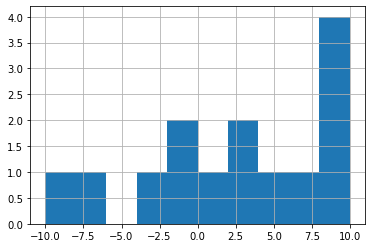

In [15]:
df["SPF_Gesamtscore_DIFFt2t1"].hist()

<AxesSubplot:>

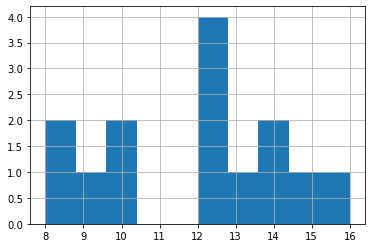

In [16]:
df["PCL_R_Faktor1"].hist()

<AxesSubplot:>

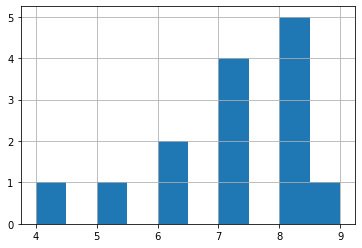

In [17]:
df["PCL_R_Lebensstil"].hist()

<AxesSubplot:>

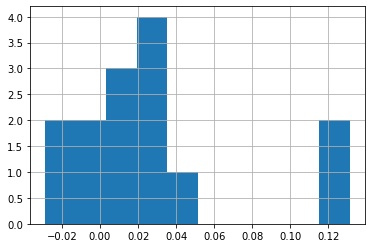

In [18]:
df["ALPHA_aucp_EC_Midline_Difft2t1"].hist()

<AxesSubplot:>

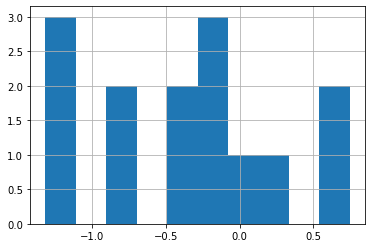

In [19]:
df["BETA_FB_Neg_Gesamt"].hist()